## Problems Explaination
We are given all the different gasture images considered in ASL (Americal Sign Language) and we need to come up with a machine learning model which can classifiy the images correctly ,or can tell us the class to which the given image belongs.
Basically we will be building a image classification model . 
<br>
## Data information
we are given 2 comma saperated file(.csv) each on them contains some rows and 785 columns
* from 2nd columns onwards each column represents the pixel values associated , representing a 28x28 grayscale image
* first column in each row represents label with the image
* There are total 24 lables (in american sign language) A-I,K-Y means A-Z except J and Z

we will be using cnn to solve this problem .

## What is an convolution neural network
A Convolutional Neural Network (ConvNet/CNN) is a Deep Learning algorithm which can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image and be able to differentiate one from the other.
<br>
A Cnn consists of 4 types of nueral layers (collection of 'nodes' operating together at a specific depth within a neural network) .
* **Convolutional Layer** :  Used to detect features
* **Non-Linearity Layer** :  Introducing non-linearity to the system
* **Pooling (Downsampling) Layer** :  Reduces weight count and checks fitness
* **Flattening Layer** :  Prepares data for Classical Neural Network
* **Fully-Connected Layer** :  Standard Neural Network used in classification
I'll not go in depth of each of these layers we will be more focused towards solving this problem,i.e implementation part.

# import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import accuracy_score,confusion_matrix
from keras.callbacks import ReduceLROnPlateau


In [2]:
#reading data
train_data = pd.read_csv("../input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv")
print(train_data.shape)
train_data.head()

(27455, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [3]:
test_data = pd.read_csv("../input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv")
print(test_data.shape)
test_data.head()

(7172, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


basically in our dataset we are given lable for the corrosponding gasture and 784 (28 x 28) pixel values represting an image <br>
* Training data contains 27455 images 
* test data contains 7172 images 

# Data preprocessing
* converting array to images(tensors)

* visulaizing lables and making sure that dataset is balanced
* performing one hot encoding for lables

In [4]:
y_train = train_data['label']
y_test = test_data['label']
del train_data['label']
del test_data['label']

In [5]:
unique_labels = y_train.unique()
unique_labels = np.sort(unique_labels)
unique_labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


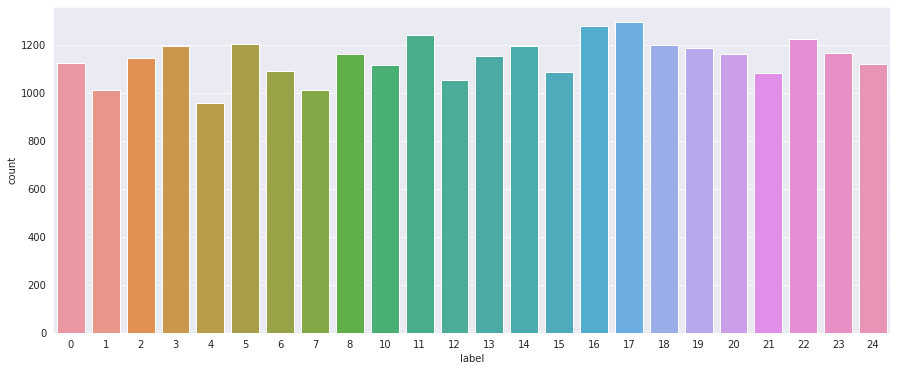

In [6]:
# visulaizing the data
plt.figure(figsize=(15,6))
sns.set_style("darkgrid");
sns.countplot(y_train);

In [7]:
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

y_train[:2]

array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]])

In [8]:
def preprocess_image(x):
    
    """ Converting the 255 values in to the value of 0 and 1"""
    x = x/255
    x = x.reshape(-1,28,28,1) # convertin it into 28 x 28 gray scaled image
    
    return x
    

In [9]:
train_x = preprocess_image(train_data.values)
test_x = preprocess_image(test_data.values)

In [10]:
def show_images(images,labels):
    fig,ax = plt.subplots(2,5)
    fig.set_size_inches(10, 6)
    k =0
    for i in range(2):
        for j in range(5):
            ax[i,j].imshow(images[k] , cmap='gray')
            ax[i,j].set_title(str(unique_labels[np.argmax(y_train[k])]))
            k = k+1;
    plt.tight_layout()

    

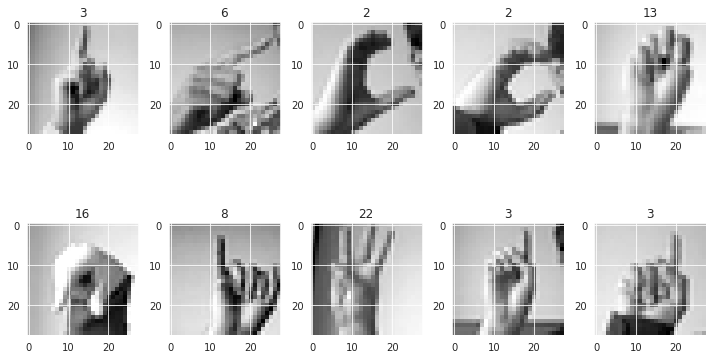

In [11]:
#let's see first 10 images from training set
show_images(train_x,y_train)

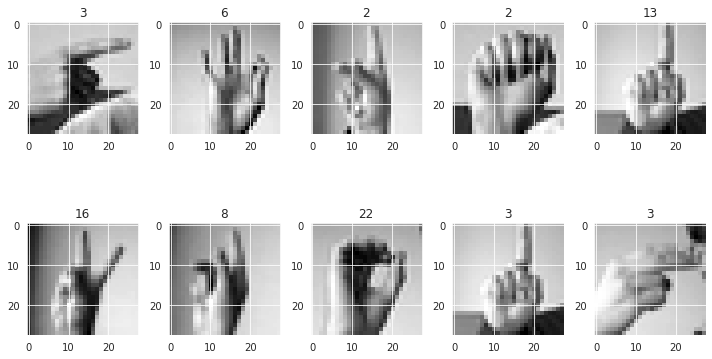

In [12]:
#let's visualize test images as well
show_images(test_x,y_test)

## Data Augmentation


In [13]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(train_x)

## Buidling the CNN model
we will be building a CNN model to classify images , as usual we will try a few of conv2d layers along with batchNormalization and regulization(dropout) and then fallten layer then dense layer .


In [14]:
def build_model(hp):  
  model = keras.Sequential([
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=75, max_value=200, step=25),
        kernel_size=(3,3),
        activation='relu',
        
        input_shape=(28,28,1)
    ),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same'),
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=50, max_value=125, step=25),
        kernel_size=(3,3),
        activation='relu',
    ),
    
    keras.layers.Dropout(
        rate = hp.Choice('drop_1_rate', values = [0.1,0.5])
    ),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same'),
    
    
    keras.layers.Conv2D(
        filters=hp.Int('conv_3_filter', min_value=25, max_value=75, step=25),
        kernel_size=(3,3),
        activation='relu',
    ),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same'),  
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=128, max_value=1024, step=32),
        activation='relu'
    ),
    keras.layers.Dropout(
        rate = hp.Choice('drop_2_rate', values = [0.1,0.3])
    ),
    keras.layers.Dense(24, activation='softmax')
  ])
  
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [15]:
tuner_search=RandomSearch(build_model,
                          objective='val_accuracy',
                          max_trials=5,directory='output',project_name="ASLdetection1")

In [16]:
tuner_search.search(train_x,y_train,epochs=5,validation_data = (test_x, y_test))

Trial 5 Complete [00h 00m 29s]
val_accuracy: 0.9392080307006836

Best val_accuracy So Far: 0.9478527903556824
Total elapsed time: 00h 03m 05s


In [17]:
model=tuner_search.get_best_models(num_models=1)[0] #this will give us the best tuned model

In [18]:
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 3, verbose=1,factor=0.5, min_lr=0.00001)

now let's train the model 

In [29]:
history = model.fit(datagen.flow(train_x,y_train, batch_size = 128) 
                    ,epochs = 10
                    , validation_data = (test_x, y_test)
                    , callbacks = [lr_reduction])

Epoch 1/10
215/215 [==============================] - 10s 49ms/step - loss: 0.0064 - accuracy: 0.9979 - val_loss: 0.0158 - val_accuracy: 0.9972
Epoch 2/10
215/215 [==============================] - 11s 49ms/step - loss: 0.0070 - accuracy: 0.9980 - val_loss: 0.0141 - val_accuracy: 0.9972
Epoch 3/10
215/215 [==============================] - 11s 52ms/step - loss: 0.0055 - accuracy: 0.9982 - val_loss: 0.0099 - val_accuracy: 0.9972
Epoch 4/10
215/215 [==============================] - 10s 49ms/step - loss: 0.0062 - accuracy: 0.9980 - val_loss: 0.0187 - val_accuracy: 0.9972

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.
Epoch 5/10
215/215 [==============================] - 11s 49ms/step - loss: 0.0062 - accuracy: 0.9984 - val_loss: 0.0119 - val_accuracy: 0.9972
Epoch 6/10
215/215 [==============================] - 11s 50ms/step - loss: 0.0043 - accuracy: 0.9981 - val_loss: 0.0122 - val_accuracy: 0.9972
Epoch 7/10
215/215 [==============================] - 1


# Analyse the trained model

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 175)       1750      
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 175)       700       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 175)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 100)       157600    
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 100)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 100)       400       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 100)         0

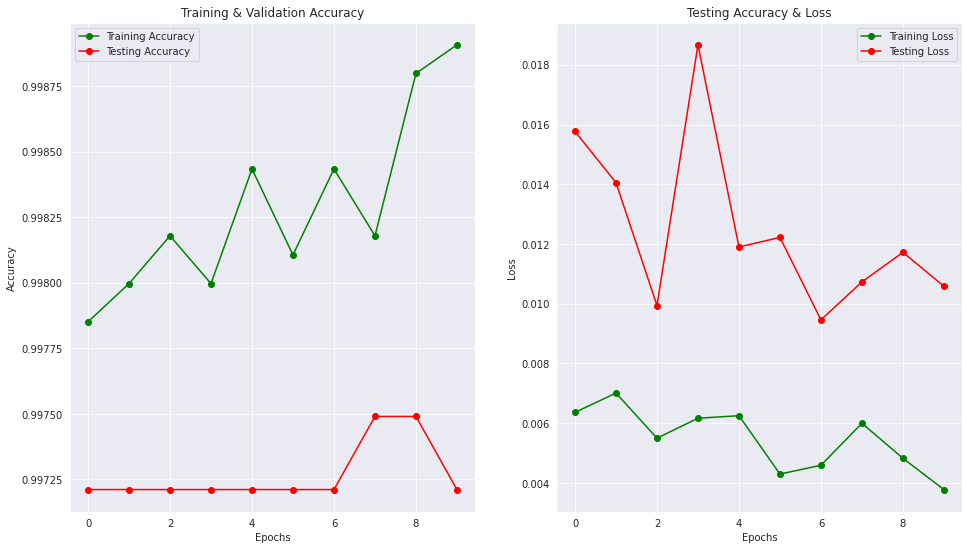

In [32]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

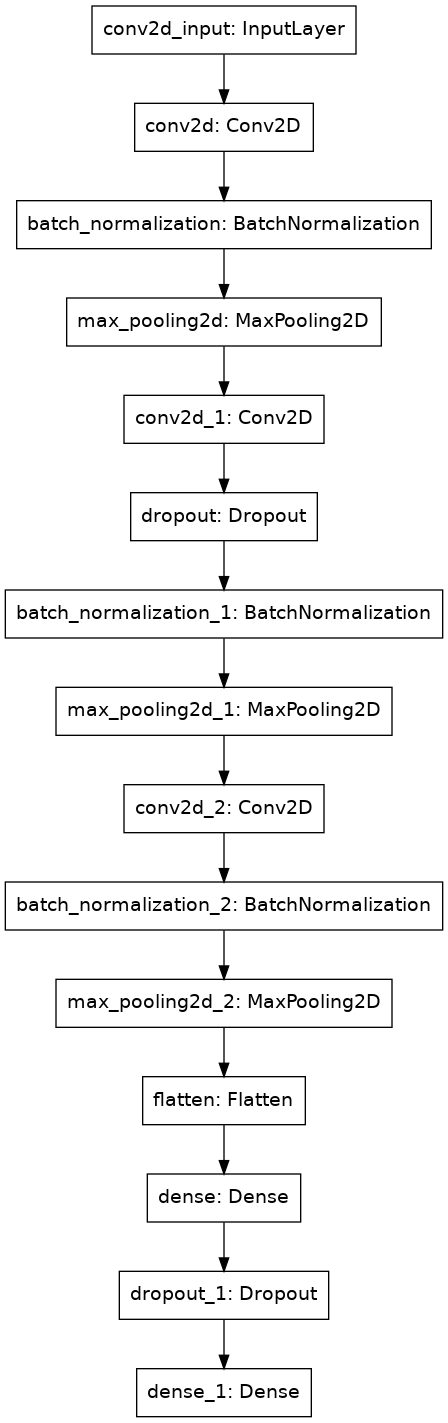

In [33]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

Confusion metrix

In [35]:
predictions = model.predict(test_x)

In [37]:
def predictions_to_labels(pred):
    labels =[]
    for p in pred:
        labels.append(unique_labels[np.argmax(p)])
    return labels

In [38]:
y_pred_labels = predictions_to_labels(predictions)
y_test_labels = predictions_to_labels(y_test)

In [39]:
accuracy_score(y_test_labels,y_pred_labels)

0.9972113775794758

<AxesSubplot:>

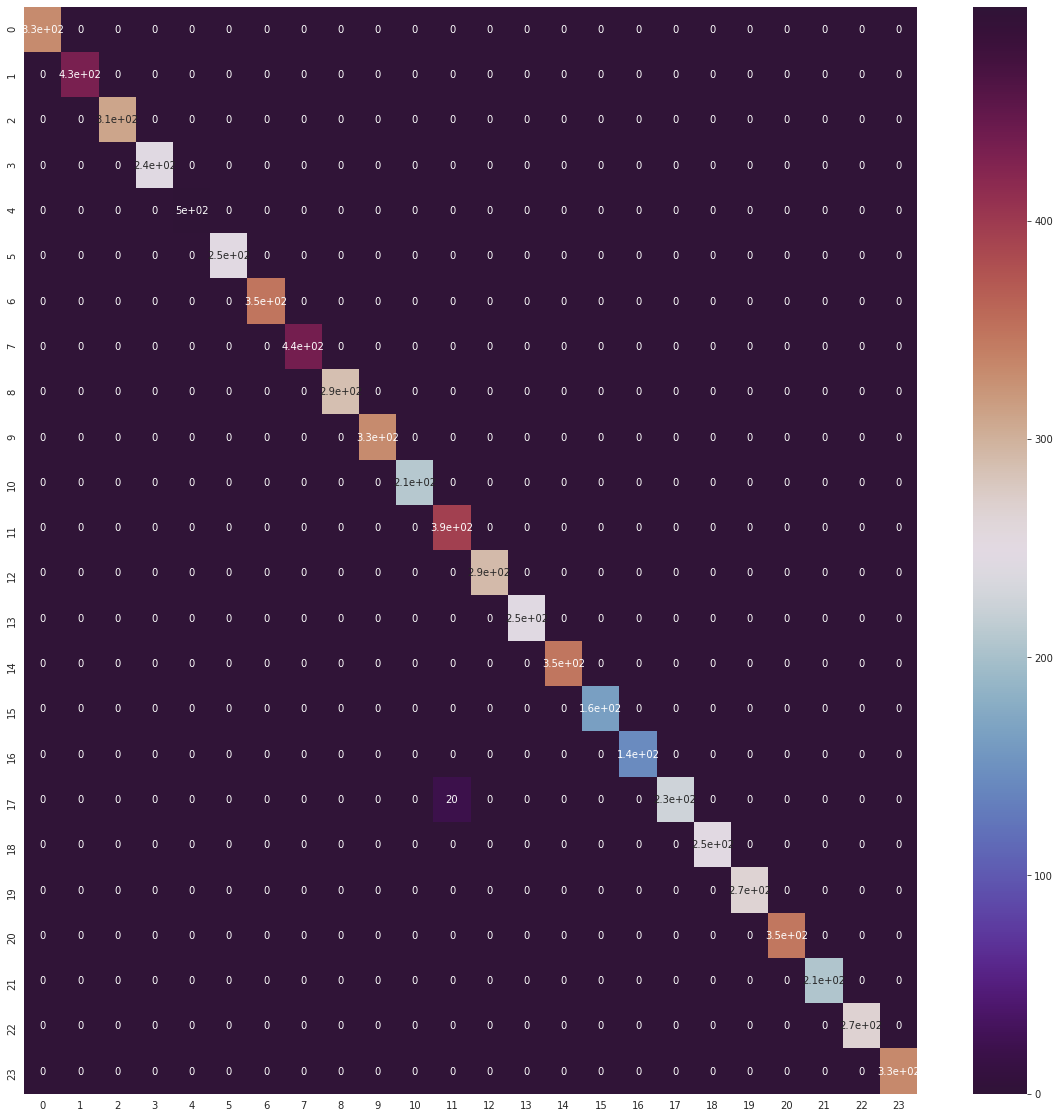

In [40]:
cm= confusion_matrix(y_test_labels,y_pred_labels)
plt.figure(figsize=(20,20))
sns.heatmap(cm,annot=True,cmap='twilight_shifted')